# Deep Learning Final Project

### Group Members:
- McKade Thomas
- Brian Nalley

In [1]:
!pip install skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import tensorflow as tf

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from skorch import NeuralNetRegressor

In [3]:
# Read in the data
df = pd.read_csv("steel_data_5_classes.csv")
# df.head()

# Change int cols to categorical
cat_cols = ['class', 'WeekStatus_Weekday', 'WeekStatus_Weekend', 'Day_of_week_Friday',
            'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday',
            'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday',
            'Load_Type_Light_Load', 'Load_Type_Maximum_Load', 'Load_Type_Medium_Load']

for col in cat_cols:
    df[col] = df[col].astype('category')

## EDA

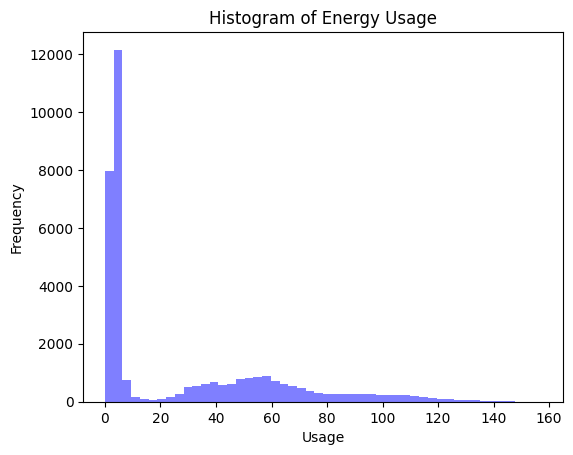

In [ ]:
# EDA - McKade
plt.xlabel('Usage')
plt.ylabel('Frequency')
plt.title('Histogram of Energy Usage')
n, bins, patches = plt.hist("Usage", 50, data = df, facecolor='blue', alpha=0.5)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [ ]:
df.describe()

,Usage,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2.tCO2.,Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


C:\Users\mckad\anaconda3\envs\ailab\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":


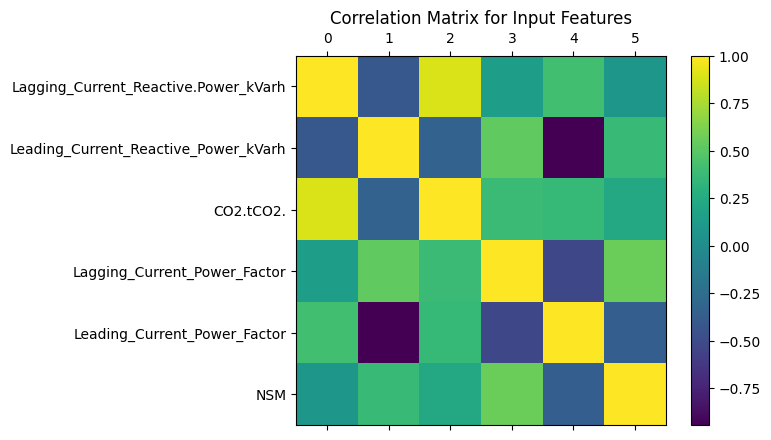

In [ ]:
figure = plt.figure()
axes = figure.add_subplot(111)
 
# using the matshow() function
caxes = axes.matshow(df.loc[:, df.columns != "Usage"].corr())
figure.colorbar(caxes)
 
# axes.set_xticklabels(['']+df.loc[:, df.columns != "Usage"].columns)
axes.set_yticklabels(['']+df.loc[:, df.columns != "Usage"].columns)
plt.title('Correlation Matrix for Input Features')
plt.show()

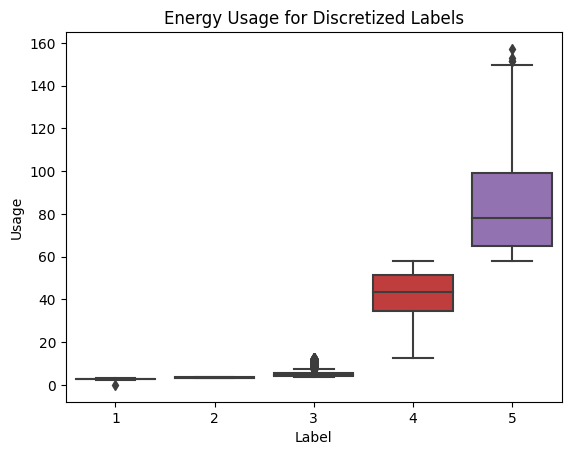

In [ ]:
# plt.figure(figsize=(8,5))
sns.boxplot(x='class',y='Usage',data=df)
plt.title("Energy Usage for Discretized Labels")
plt.xlabel('Label')
plt.show()

## Prepare the Data

In [4]:
#Setting a seed for torch
torch.manual_seed(14296) 

# Test-train split
X = df.drop(['class'], axis = 1)
y = torch.tensor(df['class'].values.astype(np.float32))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=42)

y_cont_train = X_train["Usage"].to_numpy()
y_cont_test = X_test["Usage"].to_numpy()
X_train = torch.tensor(X_train.drop(['Usage'], axis = 1).values)
X_test = torch.tensor(X_test.drop(['Usage'], axis = 1).values)

## Perform the Simulation

In [9]:
# Model with one hidden layer
class NeuralNet1(nn.Module):
    
    def __init__(self, hidden_size: int, input_size: int = 18):
        super(NeuralNet1, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [5]:
# Model with two hidden layers
class NeuralNet2(nn.Module):
    
    def __init__(self, hidden_size: int, input_size: int = 18):
        super(NeuralNet2, self).__init__()

        self.fc1 = nn.Linear(input_size,hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):

        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

Tuning Hyperparameters (Learning Rate & Hidden Size)

In [6]:
model = NeuralNetRegressor(module = NeuralNet2(hidden_size = 100), 
                             max_epochs = 30,
                             criterion = nn.MSELoss, 
                             optimizer = torch.optim.Adam,
                             lr = 0.001,
                             batch_size = 128,
                             optimizer__weight_decay = 0.001,
                             verbose=0)

In [27]:
# Grid Search

grid = {
    'lr': [0.001, 0.005],
    'batch_size': [64, 128, 256],
    'optimizer__weight_decay': [0.001, 0.005],
    'max_epochs':  [10, 30, 50]
}

gs = GridSearchCV(model, grid, refit = True, cv = 5, scoring = 'neg_root_mean_squared_error')

In [28]:
# Hidden size of 100

gs.fit(X_train.float(), y_train.reshape(-1, 1))

#Report Best Parameters
print(gs.best_score_, gs.best_params_)

-0.8472367286682129 {'batch_size': 128, 'lr': 0.001, 'max_epochs': 50, 'optimizer__weight_decay': 0.001}


With 30 epochs, best learning rate was 0.005, with 50 epochs it was 0.001.  RMSE decreased from 0.0948 to 0.847 from 30 to 50 epochs.

In [31]:
# Run Monte Carlo Simulation
def run_simulation(MC: int, hidden_sizes: list, epochs: int = 10) -> None:
    """
    Repeats the modeling process MC times and visualizes the results.
    - param MC: number of times to run the simulation.
    - param hidden_sizes: contains the values for the hidden size layer of the network.
    - param epochs: the number of epochs for the network to train on.
    """
    print(f'STARTING SIMULATION WITH {len(hidden_sizes)} SIZES...')
    full_timer = time.perf_counter()
    all_binned_rmse = []
    all_cont_rmse = []

    for i in range(0, MC):
        timer = time.perf_counter()
        a = []
        b = []
        print(f'--Begin Iteration {i+1} / {MC}')
        a, b = run_model(hidden_sizes)
        all_binned_rmse.append(a)
        all_cont_rmse.append(b)
        print(f'----Completed in {round(time.perf_counter() - timer,2)}s')
    
    binned_df = pd.DataFrame(all_binned_rmse)
    cont_df = pd.DataFrame(all_cont_rmse)
    plot_results(hidden_sizes, binned_df.mean(axis=0), cont_df.mean(axis=0))
    print(f'SIMULATION COMPLETED IN {round(time.perf_counter() - full_timer,2)}s')
    
def run_model(hidden_sizes: list, epochs: int = 10) -> list:
    """
    Creates a neural network with a single hidden layer of a given size trained 
    on synthetic binned labels and compares performance for the NN and a LM trained
    on the predictions from the NN that learns the original continuous response.
    - param hidden_sizes: Contains the values for the hidden size layer of the network.
    - param epochs: Number of epochs for the network to train on.
    
    - return: A list of two lists. The first list is the RMSE for each binned model, the
        second list is the RMSE for each continuous model.
    """
    binned_rmse = []
    cont_rmse = []
    for size in hidden_sizes:
        model = NeuralNetRegressor(module = NeuralNet2(hidden_size = size), 
                             max_epochs = epochs,
                             criterion = nn.MSELoss, 
                             optimizer = torch.optim.Adam,
                             lr = 0.001,
                             batch_size = 128,
                             optimizer__weight_decay = 0.001,
                             verbose=0)

        model.fit(X_train.float(), y_train.reshape(-1, 1))
        y_preds = model.predict(X_test.float())
        binned_rmse.append(np.sqrt(mean_squared_error(y_preds, y_test.float())))
        
        reg = LinearRegression().fit(y_preds, y_cont_test)
        cont_preds = reg.predict(y_preds)
        cont_rmse.append(np.sqrt(mean_squared_error(cont_preds, y_test.float())))
    return [binned_rmse, cont_rmse]

def plot_results(hidden_sizes: list, binned_rmse: list, cont_rmse: list) -> None:
    """
    Visualizes the performance of the binned models vs the continuous.
    - param hidden_sizes: Contains the values for the hidden size layer of the network.
    - binned_rmse: Contains the RMSE for each value of hidden_size for the binned model, 
        averaged across MC simulations.
    - cont_rmse: Contains the RMSE for each value of hidden_size for the continuous model, 
        averaged across MC simulations.
    """
    fig, ax1 = plt.subplots() 
    ax1.set_xlabel('Log10 Hidden Size') 
    ax1.set_ylabel('Binned RMSE', color = 'blue', alpha = 0.5) 
    ax1.plot(np.log10(hidden_sizes), binned_rmse, color = 'blue', alpha = 0.5) 
    ax1.tick_params(axis ='y', labelcolor = 'blue') 

    ax2 = ax1.twinx() 
    ax2.set_ylabel('Continuous RMSE', color = 'red', alpha = 0.5) 
    ax2.plot(np.log10(hidden_sizes), cont_rmse, color = 'red', alpha = 0.5) 
    ax2.tick_params(axis ='y', labelcolor = 'red')
    plt.show()

In [ ]:
hidden = [round(10**x) for x in np.arange(0, 3, 0.1)]
run_simulation(MC = 50, hidden_sizes = hidden)

STARTING SIMULATION WITH 30 SIZES...
--Begin Iteration 1 / 50


Test to see how long a run will take with different numbers of epochs

STARTING SIMULATION WITH 30 SIZES...
--Begin Iteration 1 / 1
----Completed in 48.51s


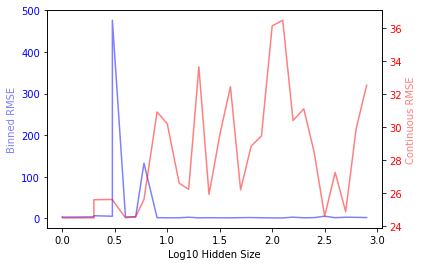

SIMULATION COMPLETED IN 48.75s


In [22]:
hidden = [round(10**x) for x in np.arange(0, 3, 0.1)]
run_simulation(MC = 1, hidden_sizes=hidden)

# 10 epochs

STARTING SIMULATION WITH 30 SIZES...
--Begin Iteration 1 / 1
----Completed in 48.34s


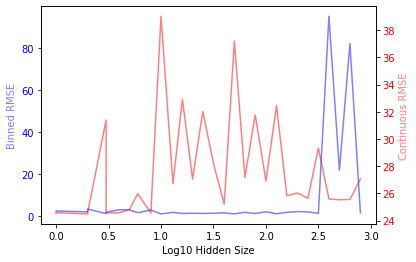

SIMULATION COMPLETED IN 48.58s


In [30]:
hidden = [round(10**x) for x in np.arange(0, 3, 0.1)]
run_simulation(MC = 1, hidden_sizes=hidden, epochs=30)

STARTING SIMULATION WITH 30 SIZES...
--Begin Iteration 1 / 1
----Completed in 48.64s


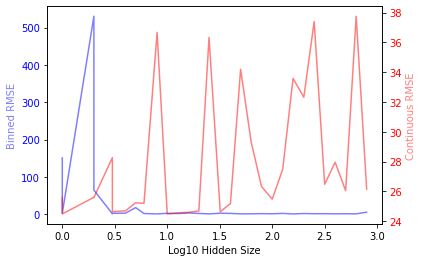

SIMULATION COMPLETED IN 48.89s


In [32]:
hidden = [round(10**x) for x in np.arange(0, 3, 0.1)]
run_simulation(MC = 1, hidden_sizes=hidden, epochs=50)